In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import math
from copy import deepcopy
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam

# Define the U-net based score prediction network

# Sampling the Frequency Vector $\mathbf{w}$

Let the total embedding dimension be $D$ (an even integer), and define  
$$
d \;=\; \frac{D}{2}
$$  
as the number of frequency pairs.

The frequency vector  
$$
\mathbf{w} \in \mathbb{R}^{d}
$$  
is sampled once at initialization from a Gaussian with standard deviation given by the `scale` hyperparameter:
$$
w_j \;\sim\; N\bigl(0,\;\text{scale}^2\bigr),
\quad
j = 1,2,\dots,d.
$$
## Time Encoding Function

Let the input timestep be $t \in \mathbb{R}$, the total embedding dimension be $D$ (even), and define  
$$
d = \frac{D}{2}
$$  
as the number of frequency pairs.  Let  
$$
\mathbf{w} = (w_{1}, w_{2}, \dots, w_{d}) \in \mathbb{R}^{d}
$$  
be the fixed frequency vector.

Then the time encoding $\phi: \mathbb{R} \to \mathbb{R}^{D}$ is given by the concatenation of sines and cosines at those frequencies:

$$
\phi(t) =
\begin{pmatrix}
\sin\bigl(2\pi\,w_{1}\,t\bigr)\\
\sin\bigl(2\pi\,w_{2}\,t\bigr)\\
\vdots\\
\sin\bigl(2\pi\,w_{d}\,t\bigr)\\[6pt]
\cos\bigl(2\pi\,w_{1}\,t\bigr)\\
\cos\bigl(2\pi\,w_{2}\,t\bigr)\\
\vdots\\
\cos\bigl(2\pi\,w_{d}\,t\bigr)
\end{pmatrix}
\;\in\;\mathbb{R}^{D}
$$

Equivalently, more compactly:

$$
\phi(t) \;=\;
\bigl[\,
\sin\bigl(2\pi\,t\,\mathbf{w}\bigr),
\;\cos\bigl(2\pi\,t\,\mathbf{w}\bigr)
\,\bigr]
\;\in\;\mathbb{R}^{D/2}\times\mathbb{R}^{D/2} \;=\; \mathbb{R}^{D}.
$$

For a batch of timesteps $\mathbf{t}\in\mathbb{R}^{B}$, you apply $\phi$ element-wise to obtain a $(B\times D)$ tensor.



In [2]:
class TimeEncoding(nn.Module):
    def __init__(self, embed_dim,scale=30):
      super().__init__()
      d =embed_dim//2
      w=torch.randn(d)*scale
      self.register_buffer('W',w,persistent=True)
    def forward(self,t):
      x_proj=t[:,None]*self.W[None,:]*2*math.pi
      return torch.cat([torch.sin(x_proj),torch.cos(x_proj)],dim=-1)

In [3]:
class Dense(nn.Module):
  def __init__(self,input_dim, output_dim):
    super().__init__()
    self.dense=nn.Linear(input_dim,output_dim)
  def forward(self,x):
    return self.dense(x)[...,None,None] #(B,output_dim)->(B, output_dim,1,1)

Assume an input activation tensor  
- $X\in\mathbb{R}^{B\times C\times H\times W}$,  
- with $C$ channels and we choose $G=4$ groups.  
Let each group have $M = C/G$ channels.  

For each sample $b$ and group $g$ (where $g=0,\dots,G-1$), define the set of channel indices  
$S_g = \{\,gM,\,gM+1,\,\dots,\, (g+1)M-1\}$.  

1. **Compute the group mean**  
$$
\mu_{b,g}
= \frac{1}{M\,H\,W}
\sum_{c\in S_g}
\sum_{h=1}^{H}
\sum_{w=1}^{W}
X_{b,c,h,w}
$$

2. **Compute the group variance**  
$$
\sigma^2_{b,g}
= \frac{1}{M\,H\,W}
\sum_{c\in S_g}
\sum_{h=1}^{H}
\sum_{w=1}^{W}
\bigl(X_{b,c,h,w} - \mu_{b,g}\bigr)^{2}
$$

3. **Normalize each element**  
For each channel $c\in S_g$:
$$
\hat X_{b,c,h,w}
= \frac{X_{b,c,h,w} - \mu_{b,g}}
       {\sqrt{\sigma^2_{b,g} + \epsilon}}
$$

4. **Apply learnable affine transform**  
With per‐channel scale $\gamma_c$ and bias $\beta_c$:
$$
Y_{b,c,h,w}
= \gamma_{c}\,\hat X_{b,c,h,w} + \beta_{c}
$$

This implements `nn.GroupNorm(4, num_channels=C)` in PyTorch.  


# For scalar data

In [4]:
class MLP2DScoreNet(nn.Module):
  def __init__(self,t_dim=64,hidden_dim=128):
    super().__init__()
    self.time_mlp=nn.Sequential(
        TimeEncoding(t_dim),
        nn.Linear(t_dim,hidden_dim),
        nn.Mish()
    )
    self.net=nn.Sequential(
        nn.Linear(2+hidden_dim,hidden_dim),
        nn.Mish(),
        nn.Linear(hidden_dim,hidden_dim),
        nn.Mish(),
        nn.Linear(hidden_dim,hidden_dim),
        nn.Mish(),
        nn.Linear(hidden_dim,2)
    )
  def forward(self,x_t,t):
    t_embed=self.time_mlp(t)
    inp=torch.cat([x_t,t_embed],dim=1)
    return self.net(inp)

# Define the SDE and Denoising Score Matching Objective

SDE is hand-designed, like any other hyper-parameters.

Now let's get our hands dirty on training. First of all, we need to specify an SDE that perturbs the data distribution $p_{0}$ to a prior distribution $p_{T}$. We choose the following SDE:

$$
dx = \sigma^{t}\,dw,\quad t\in[0,1].
$$

In this case,

$$
p_{0t}\bigl(x(t)\mid x(0)\bigr)
= N\Bigl(
x(t)\;;\;x(0),\;\frac{1}{2\log\sigma}\bigl(\sigma^{2t}-1\bigr)\,I
\Bigr).
$$

and we can choose the weighting function

$$
\lambda(t) \;=\;\mathrm{variance}
\;=\;\frac{1}{2\log\sigma}\bigl(\sigma^{2t}-1\bigr).
$$

When $\sigma$ is large, the prior distribution $p_{t=1}$ is

$$
p_{t=1}(x)
=\int p_{0}(y)\,N\Bigl(x ; y,\; \tfrac{1}{2\log\sigma}(\sigma^{2}-1)\,I\Bigr)\,dy
\approx N\Bigl(x ; 0,\; \tfrac{1}{2\log\sigma}(\sigma^{2}-1)\,I\Bigr),
$$

which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\tfrac{1}{2\log\sigma}(\sigma^{2t}-1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_{0}$ to a simple Gaussian distribution $p_{1}$.


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of p_{0t}(x(t) | x(0))."""
    if not isinstance(t, torch.Tensor):
        t = torch.tensor(t, device=device, dtype=torch.float32)
    return torch.sqrt((sigma**(2*t) - 1) / (2 * np.log(sigma)))


def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE."""
    if not isinstance(t, torch.Tensor):
        t = torch.tensor(t, device=device, dtype=torch.float32)
    return sigma**t


sigma = 25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

The loss is defined as:
$$
\theta^{*} \;=\; \arg\min_{\theta}\; \mathbb{E}_{t}\biggl\{\;\lambda(t)\;\mathbb{E}_{x(0)}\;\mathbb{E}_{x(t)\mid x(0)}\bigl[\bigl\lVert s_{\theta}\bigl(x(t),\,t\bigr)\;-\;\nabla_{x(t)}\log p_{0t}\bigl(x(t)\mid x(0)\bigr)\bigr\rVert_{2}^{2}\bigr]\biggr\}.
$$
where in this speical case:
$$ \nabla_{x(t)}\log p_{0t}\bigl(x(t)\mid x(0)\bigr)=-\frac{\epsilon}{\sigma} $$
$$ \lambda(t)=\sigma^2$$

In [6]:
class EMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super(EMA, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform EMA on different device from model if set
        if self.device is not None:
            self.module.to(device=self.device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(),
                                      model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(
            model,
            update_fn=lambda e, m: self.decay * e + (1.0 - self.decay) * m
        )

    def set(self, model):
        self._update(
            model,
            update_fn=lambda e, m: m
        )

## Training for scalar data

In [7]:
def loss_fn(model, x0, marginal_prob_std_fn, eps=1e-5):
    """
    Denoising score matching loss for 2D data.

    Args:
        model: score network
        x0: clean data samples (B, 2)
        marginal_prob_std_fn: function to compute std at time t
        eps: small epsilon for numerical stability

    Returns:
        Loss value
    """
    # Random time
    t = torch.rand(x0.shape[0], device=x0.device) * (1.0 - eps) + eps

    # Sample noise
    z = torch.randn_like(x0)

    # Get std at time t
    std = marginal_prob_std_fn(t).unsqueeze(1)  # (B, 1)

    # Perturb data
    perturbed_x0 = x0 + z * std

    # Predict score
    score = model(perturbed_x0, t)

    # Compute loss: E[||s_θ(x_t, t) - (-z/std)||^2] weighted by std^2
    target = -z / std
    loss = torch.mean(torch.sum((score - target)**2, dim=1) * std.squeeze(1)**2)

    return loss

Creating new data points at (-10,10)

New dataset statistics:
  Dataset size: 100000
  Data mean: tensor([ 0.0464, -0.0056])
  Data std: tensor([10.2133,  2.1190])

New cluster analysis:
  Left cluster mean: [-9.983102e+00 -9.950980e-03]
  Right cluster mean: [ 9.9963646e+00 -1.1986633e-03]
  Left cluster std: [2.999873 2.995275]
  Right cluster std: [0.27107942 0.20889038]
  Cluster separation: 20.0


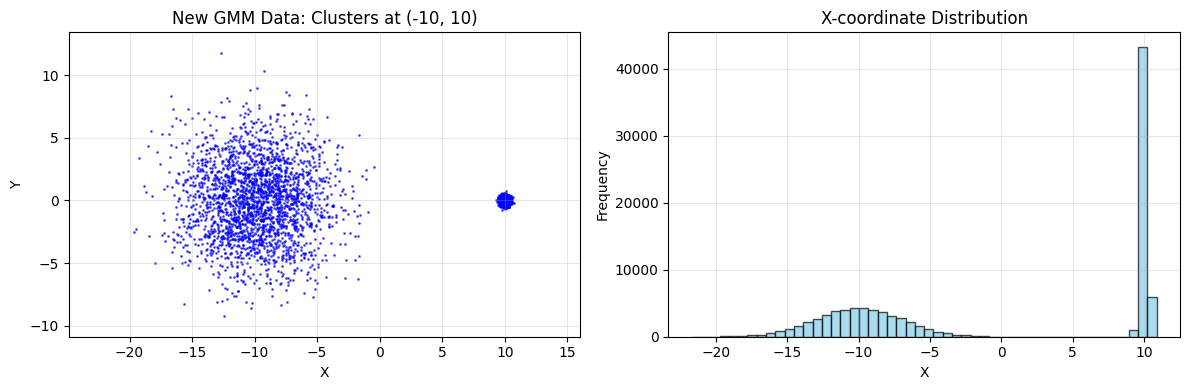

In [8]:
# Create new dataset with clusters at (-10, 10)
batch_size = 128
N = 100_000
sigma_data = 1.0

# Create two-component Gaussian mixture with better separation
mean_new = torch.tensor([[-10.0, 0.0], [10.0, 0.0]], device=device)
comp_ids_new = torch.randint(0, 2, (N,), device=device)
mus_new = mean_new[comp_ids_new]
vars=torch.tensor([3,0.2],device=device)
noise_new = torch.randn(N, 2, device=device) * vars[comp_ids_new].unsqueeze(1)
x0_new = mus_new + noise_new

# Create new dataset and loader
dataset_new = TensorDataset(x0_new.cpu())
loader_new = DataLoader(dataset_new, batch_size=batch_size, shuffle=True)

print(f"New dataset statistics:")
print(f"  Dataset size: {N}")
print(f"  Data mean: {x0_new.mean(dim=0)}")
print(f"  Data std: {x0_new.std(dim=0)}")

# Verify the new clusters
real_data_new = x0_new.cpu().numpy()
left_cluster_new = real_data_new[real_data_new[:, 0] < 0]
right_cluster_new = real_data_new[real_data_new[:, 0] > 0]

print(f"\nNew cluster analysis:")
print(f"  Left cluster mean: {np.mean(left_cluster_new, axis=0)}")
print(f"  Right cluster mean: {np.mean(right_cluster_new, axis=0)}")
print(f"  Left cluster std: {np.std(left_cluster_new, axis=0)}")
print(f"  Right cluster std: {np.std(right_cluster_new, axis=0)}")
print(f"  Cluster separation: {np.mean(right_cluster_new, axis=0)[0] - np.mean(left_cluster_new, axis=0)[0]:.1f}")

# Visualize the new data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(real_data_new[:5000, 0], real_data_new[:5000, 1], s=1, alpha=0.6, color='blue')
plt.title('New GMM Data: Clusters at (-10, 10)')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.hist(real_data_new[:, 0], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('X-coordinate Distribution')
plt.xlabel('X')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


New model parameters: 215042
Starting training for 50 epochs...


Epoch 1: 100%|██████████| 782/782 [00:13<00:00, 59.78it/s, loss=1.4584, step=782]


[Epoch 01] Loss: 1.4584e+00


Epoch 2: 100%|██████████| 782/782 [00:13<00:00, 59.89it/s, loss=1.1250, step=1564]


[Epoch 02] Loss: 1.1250e+00


Epoch 3: 100%|██████████| 782/782 [00:13<00:00, 57.66it/s, loss=0.9790, step=2346]


[Epoch 03] Loss: 9.7904e-01


Epoch 4: 100%|██████████| 782/782 [00:13<00:00, 58.63it/s, loss=0.9240, step=3128]


[Epoch 04] Loss: 9.2399e-01


Epoch 5: 100%|██████████| 782/782 [00:12<00:00, 60.96it/s, loss=0.8896, step=3910]


[Epoch 05] Loss: 8.8957e-01
   Validation - Left: [-0.01452758  0.01810964], Right: [-0.02717263 -0.04905   ], Center: [ 0.02982729 -0.01732597]


Epoch 6: 100%|██████████| 782/782 [00:12<00:00, 60.94it/s, loss=0.8752, step=4692]


[Epoch 06] Loss: 8.7525e-01


Epoch 7: 100%|██████████| 782/782 [00:12<00:00, 61.65it/s, loss=0.8660, step=5474]


[Epoch 07] Loss: 8.6597e-01


Epoch 8: 100%|██████████| 782/782 [00:12<00:00, 60.73it/s, loss=0.8567, step=6256]


[Epoch 08] Loss: 8.5670e-01


Epoch 9: 100%|██████████| 782/782 [00:13<00:00, 58.53it/s, loss=0.8465, step=7038]


[Epoch 09] Loss: 8.4647e-01


Epoch 10: 100%|██████████| 782/782 [00:12<00:00, 60.69it/s, loss=0.8443, step=7820]


[Epoch 10] Loss: 8.4429e-01
   Validation - Left: [-0.17096673  0.04558337], Right: [-0.12010259 -0.03819554], Center: [0.07107965 0.00134972]


Epoch 11: 100%|██████████| 782/782 [00:13<00:00, 59.98it/s, loss=0.8390, step=8602]


[Epoch 11] Loss: 8.3898e-01


Epoch 12: 100%|██████████| 782/782 [00:12<00:00, 60.23it/s, loss=0.8323, step=9384]


[Epoch 12] Loss: 8.3230e-01


Epoch 13: 100%|██████████| 782/782 [00:12<00:00, 60.37it/s, loss=0.8317, step=10166]


[Epoch 13] Loss: 8.3166e-01


Epoch 14: 100%|██████████| 782/782 [00:13<00:00, 59.75it/s, loss=0.8325, step=10948]


[Epoch 14] Loss: 8.3251e-01


Epoch 15: 100%|██████████| 782/782 [00:13<00:00, 59.81it/s, loss=0.8286, step=11730]


[Epoch 15] Loss: 8.2860e-01
   Validation - Left: [-0.21672879  0.04778327], Right: [-0.32174653 -0.01411757], Center: [0.0510658  0.01312384]


Epoch 16: 100%|██████████| 782/782 [00:12<00:00, 60.47it/s, loss=0.8175, step=12512]


[Epoch 16] Loss: 8.1746e-01


Epoch 17: 100%|██████████| 782/782 [00:12<00:00, 61.11it/s, loss=0.8204, step=13294]


[Epoch 17] Loss: 8.2035e-01


Epoch 18: 100%|██████████| 782/782 [00:12<00:00, 60.47it/s, loss=0.8313, step=14076]


[Epoch 18] Loss: 8.3131e-01


Epoch 19: 100%|██████████| 782/782 [00:12<00:00, 60.44it/s, loss=0.8246, step=14858]


[Epoch 19] Loss: 8.2461e-01


Epoch 20: 100%|██████████| 782/782 [00:12<00:00, 60.69it/s, loss=0.8325, step=15640]


[Epoch 20] Loss: 8.3252e-01
   Validation - Left: [-0.19855659  0.02939755], Right: [-0.4065579  -0.00271577], Center: [-0.0823093   0.01467261]


Epoch 21: 100%|██████████| 782/782 [00:12<00:00, 61.27it/s, loss=0.8269, step=16422]


[Epoch 21] Loss: 8.2687e-01


Epoch 22: 100%|██████████| 782/782 [00:12<00:00, 61.16it/s, loss=0.8277, step=17204]


[Epoch 22] Loss: 8.2768e-01


Epoch 23: 100%|██████████| 782/782 [00:12<00:00, 60.37it/s, loss=0.8283, step=17986]


[Epoch 23] Loss: 8.2828e-01


Epoch 24: 100%|██████████| 782/782 [00:12<00:00, 60.69it/s, loss=0.8305, step=18768]


[Epoch 24] Loss: 8.3048e-01


Epoch 25: 100%|██████████| 782/782 [00:12<00:00, 61.13it/s, loss=0.8240, step=19550]


[Epoch 25] Loss: 8.2401e-01
   Validation - Left: [-0.17347167  0.01530692], Right: [-0.3458383  -0.00282974], Center: [-0.26048437  0.01692013]


Epoch 26: 100%|██████████| 782/782 [00:12<00:00, 60.73it/s, loss=0.8218, step=20332]


[Epoch 26] Loss: 8.2181e-01


Epoch 27: 100%|██████████| 782/782 [00:12<00:00, 61.09it/s, loss=0.8241, step=21114]


[Epoch 27] Loss: 8.2408e-01


Epoch 28: 100%|██████████| 782/782 [00:13<00:00, 60.00it/s, loss=0.8202, step=21896]


[Epoch 28] Loss: 8.2020e-01


Epoch 29: 100%|██████████| 782/782 [00:12<00:00, 61.23it/s, loss=0.8255, step=22678]


[Epoch 29] Loss: 8.2549e-01


Epoch 30: 100%|██████████| 782/782 [00:12<00:00, 60.50it/s, loss=0.8209, step=23460]


[Epoch 30] Loss: 8.2094e-01
   Validation - Left: [-0.14006917  0.00877499], Right: [-0.24190266 -0.00316742], Center: [-0.43442076  0.01896667]


Epoch 31: 100%|██████████| 782/782 [00:12<00:00, 61.25it/s, loss=0.8197, step=24242]


[Epoch 31] Loss: 8.1972e-01


Epoch 32: 100%|██████████| 782/782 [00:12<00:00, 61.86it/s, loss=0.8239, step=25024]


[Epoch 32] Loss: 8.2387e-01


Epoch 33: 100%|██████████| 782/782 [00:12<00:00, 62.68it/s, loss=0.8258, step=25806]


[Epoch 33] Loss: 8.2575e-01


Epoch 34: 100%|██████████| 782/782 [00:12<00:00, 61.49it/s, loss=0.8208, step=26588]


[Epoch 34] Loss: 8.2076e-01


Epoch 35: 100%|██████████| 782/782 [00:12<00:00, 62.50it/s, loss=0.8243, step=27370]


[Epoch 35] Loss: 8.2428e-01
   Validation - Left: [-0.11291762  0.00268123], Right: [-0.1531945  -0.00182965], Center: [-0.5403295  0.0158815]


Epoch 36: 100%|██████████| 782/782 [00:12<00:00, 61.52it/s, loss=0.8244, step=28152]


[Epoch 36] Loss: 8.2444e-01


Epoch 37: 100%|██████████| 782/782 [00:12<00:00, 61.36it/s, loss=0.8266, step=28934]


[Epoch 37] Loss: 8.2663e-01


Epoch 38: 100%|██████████| 782/782 [00:12<00:00, 62.53it/s, loss=0.8160, step=29716]


[Epoch 38] Loss: 8.1602e-01


Epoch 39: 100%|██████████| 782/782 [00:12<00:00, 60.87it/s, loss=0.8321, step=30498]


[Epoch 39] Loss: 8.3212e-01


Epoch 40: 100%|██████████| 782/782 [00:12<00:00, 60.74it/s, loss=0.8153, step=31280]


[Epoch 40] Loss: 8.1535e-01
   Validation - Left: [-0.09639783 -0.00392215], Right: [-0.09545167  0.00083558], Center: [-0.6093806   0.01373677]


Epoch 41: 100%|██████████| 782/782 [00:12<00:00, 60.99it/s, loss=0.8195, step=32062]


[Epoch 41] Loss: 8.1946e-01


Epoch 42: 100%|██████████| 782/782 [00:12<00:00, 60.92it/s, loss=0.8208, step=32844]


[Epoch 42] Loss: 8.2078e-01


Epoch 43: 100%|██████████| 782/782 [00:12<00:00, 61.98it/s, loss=0.8106, step=33626]


[Epoch 43] Loss: 8.1056e-01


Epoch 44: 100%|██████████| 782/782 [00:12<00:00, 61.45it/s, loss=0.8196, step=34408]


[Epoch 44] Loss: 8.1959e-01


Epoch 45: 100%|██████████| 782/782 [00:12<00:00, 61.81it/s, loss=0.8291, step=35190]


[Epoch 45] Loss: 8.2914e-01
   Validation - Left: [-0.07634369 -0.00390035], Right: [-0.06210925  0.00265026], Center: [-0.65309364  0.01185671]


Epoch 46: 100%|██████████| 782/782 [00:13<00:00, 59.61it/s, loss=0.8193, step=35972]


[Epoch 46] Loss: 8.1934e-01


Epoch 47: 100%|██████████| 782/782 [00:12<00:00, 60.59it/s, loss=0.8213, step=36754]


[Epoch 47] Loss: 8.2133e-01


Epoch 48: 100%|██████████| 782/782 [00:12<00:00, 61.73it/s, loss=0.8238, step=37536]


[Epoch 48] Loss: 8.2375e-01


Epoch 49: 100%|██████████| 782/782 [00:12<00:00, 61.87it/s, loss=0.8102, step=38318]


[Epoch 49] Loss: 8.1018e-01


Epoch 50: 100%|██████████| 782/782 [00:12<00:00, 60.93it/s, loss=0.8249, step=39100]


[Epoch 50] Loss: 8.2490e-01
   Validation - Left: [-0.0629965  -0.00381343], Right: [-0.04060362  0.00267716], Center: [-0.68227595  0.00694207]

✅ Training completed!


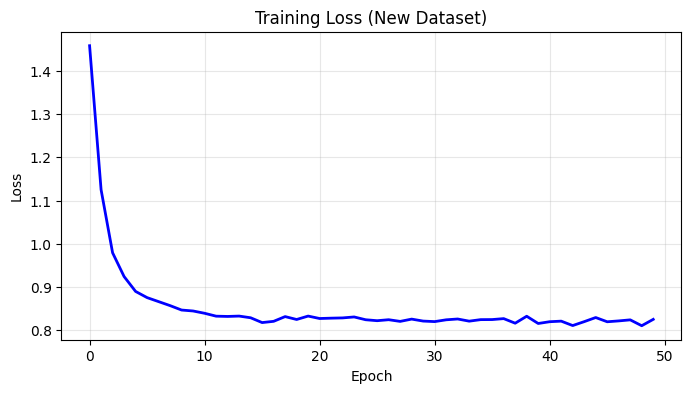

Initial loss: 1.4584e+00
Final loss: 8.2490e-01
Loss reduction: 43.4%


In [9]:
# Create a new model for the new dataset
score_model_new = MLP2DScoreNet(t_dim=64, hidden_dim=256).to(device)
ema_new = EMA(score_model_new, decay=0.9999, device=device)

print(f"New model parameters: {sum(p.numel() for p in score_model_new.parameters())}")

# Manual optimizer setup
lr = 1e-4
beta1, beta2 = 0.9, 0.999
eps_opt = 1e-8

# Initialize Adam states for new model
m_dict_new = {}
v_dict_new = {}
step_new = 0

for name, param in score_model_new.named_parameters():
    m_dict_new[name] = torch.zeros_like(param)
    v_dict_new[name] = torch.zeros_like(param)

# Training loop for new dataset
n_epochs = 50  # More epochs for better convergence
train_losses_new = []

print(f"Starting training for {n_epochs} epochs...")

for epoch in range(1, n_epochs + 1):
    total_loss = 0.0
    count = 0

    pbar = tqdm(loader_new, desc=f"Epoch {epoch}")

    for batch_idx, (x0_batch,) in enumerate(pbar):
        x0_batch = x0_batch.to(device)

        # Zero gradients
        for param in score_model_new.parameters():
            if param.grad is not None:
                param.grad.zero_()

        # Forward pass
        loss = loss_fn(score_model_new, x0_batch, marginal_prob_std_fn)
        loss.backward()

        # Manual Adam update
        step_new += 1

        for name, param in score_model_new.named_parameters():
            if param.grad is not None:
                grad = param.grad.data

                # Gradient clipping
                grad_norm = torch.norm(grad)
                if grad_norm > 1.0:
                    grad = grad / grad_norm

                # Adam update
                m_dict_new[name] = beta1 * m_dict_new[name] + (1 - beta1) * grad
                v_dict_new[name] = beta2 * v_dict_new[name] + (1 - beta2) * grad * grad

                # Bias correction
                m_hat = m_dict_new[name] / (1 - beta1**step_new)
                v_hat = v_dict_new[name] / (1 - beta2**step_new)

                # Update parameters
                param.data -= lr * m_hat / (torch.sqrt(v_hat) + eps_opt)

        # Update EMA
        ema_new.update(score_model_new)

        total_loss += loss.item() * x0_batch.size(0)
        count += x0_batch.size(0)

        pbar.set_postfix({
            'loss': f'{total_loss/count:.4f}',
            'step': step_new
        })

    avg_loss = total_loss / count
    train_losses_new.append(avg_loss)

    print(f"[Epoch {epoch:02d}] Loss: {avg_loss:.4e}")

    # Quick validation every 5 epochs
    if epoch % 5 == 0:
        score_model_new.eval()
        with torch.no_grad():
            test_points = torch.tensor([[-10.0, 0.0], [10.0, 0.0], [0.0, 0.0]], device=device)
            test_t = torch.full((3,), 0.5, device=device)
            scores = ema_new.module(test_points, test_t)
            print(f"   Validation - Left: {scores[0].cpu().numpy()}, Right: {scores[1].cpu().numpy()}, Center: {scores[2].cpu().numpy()}")
        score_model_new.train()

print("\n✅ Training completed!")

# Plot training curve
plt.figure(figsize=(8, 4))
plt.plot(train_losses_new, 'b-', linewidth=2)
plt.title('Training Loss (New Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Initial loss: {train_losses_new[0]:.4e}")
print(f"Final loss: {train_losses_new[-1]:.4e}")
print(f"Loss reduction: {(train_losses_new[0] - train_losses_new[-1]) / train_losses_new[0] * 100:.1f}%")

#Sampling

##Euler Sampling

Recall that for any SDE of the form

$$
dx = f(x, t)\,dt + g(t)\,dw,
$$

the reverse‐time SDE is given by

$$
dx = \bigl[f(x, t) - g(t)^2\,\nabla_x\log p_t(x)\bigr]\,dt + g(t)\,d\bar w.
$$

Since we have chosen the forward SDE to be

$$
dx = \sigma^t\,dw,\quad t\in[0,1],
$$

the reverse‐time SDE is

$$
dx = -\,\sigma^{2t}\,\nabla_x\log p_t(x)\,dt + \sigma^t\,d\bar w.
$$

In particular, using our time‐dependent score‐based model, the reverse‐time SDE can be approximated by

$$
dx = -\,\sigma^{2t}\,s_\theta(x,t)\,dt + \sigma^t\,d\bar w.
$$

To sample from our time‐dependent score‐based model $s_\theta(x,t)$, we first draw a sample from the prior distribution

$$
p_{1} \approx \mathcal{N}\Bigl(x;0,\;\tfrac{1}{2\log\sigma}(\sigma^{2}-1)\,I\Bigr),
$$

and then solve the reverse‐time SDE with numerical methods, such as the Euler–Maruyama approach.  Replacing $dt$ with $\Delta t$ and $dw$ with $z_t\sim\mathcal{N}(0,\,g^2(t)\,\Delta t\,I)$, we obtain the iteration

$$
x_{\,t-\Delta t}
= x_{t}
  + \sigma^{2t}\,s_\theta(x_t,\,t)\,\Delta t
  + \sigma^t\,\sqrt{\Delta t}\;z_t,
\quad
z_t \sim \mathcal{N}(0,\,I).
$$


In [13]:
import torch
import tqdm

num_steps=500
def euler_sampler_2d(score_model, marginal_prob_std, diffusion_coeff, batch_size=64, num_steps=num_steps, device='cuda', eps=1e-3):
    """
    Euler sampler for 2D scalar data (Gaussian mixture model).

    Args:
        score_model: score network that takes (x_t, t) and returns score
        marginal_prob_std: function that computes std at time t
        diffusion_coeff: function that computes diffusion coefficient g(t)
        batch_size: number of samples to generate
        num_steps: number of discretization steps
        device: 'cuda' or 'cpu'
        eps: small epsilon to avoid numerical issues

    Returns:
        Generated samples of shape (batch_size, 2)
    """
    # Initialize from prior at t=1
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t).unsqueeze(1)

    # Time steps from 1 to eps
    time_steps = torch.linspace(1.0, eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]

    x = init_x
    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps, desc='Euler sampling (2D)'):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)

            # Compute mean of reverse process
            score = score_model(x, batch_time_step)
            mean_x = x + (g**2).unsqueeze(1) * score * step_size

            # Add noise
            z = torch.randn_like(x)
            x = mean_x + torch.sqrt(step_size) * g.unsqueeze(1) * z

    return mean_x


## PC sampler

corrector:
$$ x_t ← x_t+α s_θ(x_t,t)+\sqrt{2α} z$$
predictor:
$$x_{t-Δt}=\mu+g_t \sqrt{Δt} z$$
where $\mu=x_t+g_t^2s_\theta (x_t,t)Δt$


##Sampler via PC sampler

In [11]:
import torch
import tqdm
import math

def pc_sampler_2d(
    score_model,
    marginal_prob_std,
    diffusion_coeff,
    batch_size=64,
    num_steps=1000,
    snr=0.16,
    device='cuda',
    eps=1e-4,
    corrector_steps=20
):
    """
    Predictor–Corrector sampler for 2-D data (e.g., Gaussian mixture).

    Args:
        score_model: a model mapping (x_t of shape (B,2), t of shape (B,)) → (B,2)
        marginal_prob_std: function t→σ̄(t)
        diffusion_coeff: function t→g(t)
        batch_size: number of samples to generate
        num_steps: number of discretization steps (time grid from 1→eps)
        snr: signal-to-noise ratio for Langevin corrector
        device: 'cuda' or 'cpu'
        eps: smallest time to end at
        corrector_steps: number of Langevin steps per time

    Returns:
        x_mean: final denoised samples of shape (batch_size,2)
    """
    # 1) Initialize from prior at t=1: x₁ ∼ N(0, σ̄(1)² I₂)
    t = torch.ones(batch_size, device=device)
    with torch.no_grad():
        std1 = marginal_prob_std(t).unsqueeze(1)          # (B,1)
        x = torch.randn(batch_size, 2, device=device) * std1  # (B,2)

    # 2) Time grid and step size
    time_steps = torch.linspace(1.0, eps, num_steps, device=device)
    dt = time_steps[0] - time_steps[1]

    # 3) Reverse SDE with Predictor–Corrector
    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps, desc='PC sampling (2D)'):
            batch_t = torch.full((batch_size,), time_step, device=device)

            # Predictor: Euler–Maruyama
            g = diffusion_coeff(time_step)                   # scalar
            score = score_model(x, batch_t)                  # (B,2)
            x_mean = x + (g**2) * score * dt                 # (B,2)
            x = x_mean + g * math.sqrt(dt) * torch.randn_like(x)

            # Corrector: Langevin MCMC
            for _ in range(corrector_steps):
                grad = score_model(x, batch_t)               # (B,2)
                # compute norms
                grad_norm  = torch.norm(grad.view(batch_size, -1), dim=1).mean()
                noise_norm = math.sqrt(2)                    # sqrt(D) for D=2
                # step size α = 2*(snr·noise_norm/grad_norm)²
                if grad_norm > 0:  # Avoid division by zero
                    alpha = (snr * noise_norm / grad_norm)**2 * 2.0
                else:
                    alpha = 0.01  # Small fallback value
                # Langevin update
                x = x + alpha * grad + math.sqrt(2*alpha) * torch.randn_like(x)

    # 4) Return final denoised mean
    return x_mean


=== TESTING NEW MODEL WITH SAMPLING ===
Generating 2000 samples with PC sampler (new model)...


PC sampling (2D): 100%|██████████| 200/200 [00:02<00:00, 85.45it/s]


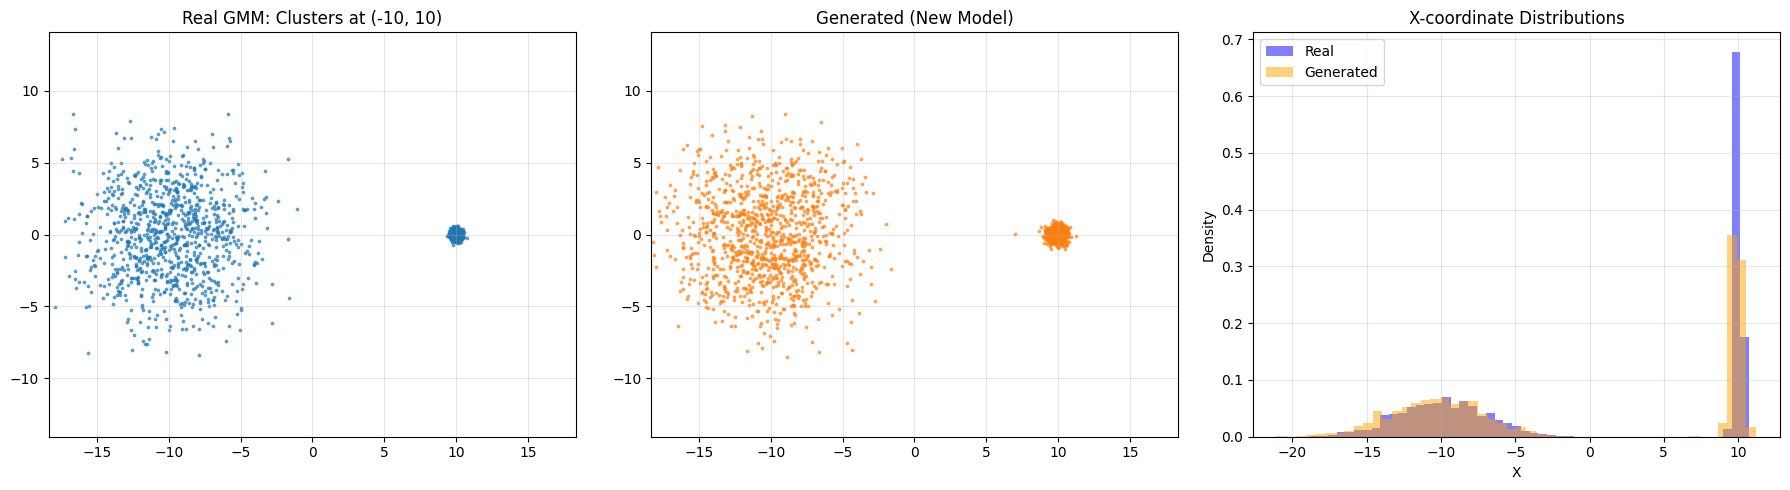


=== DETAILED ANALYSIS (NEW MODEL) ===
Real data statistics:
  Mean: [ 0.28415713 -0.00763024]
  Std: [10.190539   2.1380775]

Generated samples statistics:
  Mean: [-1.1154841   0.00908891]
  Std: [10.371078   2.3121715]

Clustering analysis:
Real data - Left cluster: 973 samples, Right cluster: 1027 samples
Generated - Left cluster: 1085 samples, Right cluster: 915 samples
Real left cluster mean: [-9.963562   -0.01430717]
Real right cluster mean: [ 9.9930401e+00 -1.3043731e-03]
Generated left cluster mean: [-10.393896     0.01275541]
Generated right cluster mean: [9.8867817e+00 4.7411574e-03]

=== QUALITY ASSESSMENT (NEW MODEL) ===
Cluster balance - Real: 0.49, Generated: 0.54
✅ Cluster balance looks good!
Cluster separation - Real: 20.0, Generated: 20.3
✅ Cluster separation looks good!



In [12]:
print("=== TESTING NEW MODEL WITH SAMPLING ===")

# Generate samples with the new trained model
M = 2000  # Number of samples to generate
gen_samples_new = []

with torch.no_grad():
    n_batches = (M + batch_size - 1) // batch_size

    print(f"Generating {M} samples with PC sampler (new model)...")
    for i in range(n_batches):
        current_batch_size = min(batch_size, M - i * batch_size)
        x_gen = pc_sampler_2d(
            score_model=ema_new.module,
            marginal_prob_std=marginal_prob_std_fn,
            diffusion_coeff=diffusion_coeff_fn,
            batch_size=current_batch_size,
            num_steps=200,  # Reduced for faster generation
            snr=0.16,
            device=device,
            eps=1e-3,
            corrector_steps=5  # Reduced for faster generation
        )
        gen_samples_new.append(x_gen.cpu().numpy())

# Flatten and trim to exactly M samples
gen_samples_new = np.concatenate(gen_samples_new, axis=0)[:M]

# Prepare the real GMM samples (new dataset)
real_samples_new = x0_new.cpu().numpy()  # shape (N,2)

# Plot comparison
plt.figure(figsize=(18, 5))

# Subplot 1: Real GMM (new dataset)
plt.subplot(1, 3, 1)
plt.scatter(real_samples_new[:M, 0], real_samples_new[:M, 1], s=3, alpha=0.6, color='C0')
plt.title("Real GMM: Clusters at (-10, 10)")
plt.axis('equal')
plt.xlim(-15, 15)
plt.ylim(-5, 5)
plt.grid(True, alpha=0.3)

# Subplot 2: Generated samples (new model)
plt.subplot(1, 3, 2)
plt.scatter(gen_samples_new[:, 0], gen_samples_new[:, 1], s=3, alpha=0.6, color='C1')
plt.title("Generated (New Model)")
plt.axis('equal')
plt.xlim(-15, 15)
plt.ylim(-5, 5)
plt.grid(True, alpha=0.3)

# Subplot 3: Histogram comparison
plt.subplot(1, 3, 3)
plt.hist(real_samples_new[:M, 0], bins=50, alpha=0.5, color='blue', label='Real', density=True)
plt.hist(gen_samples_new[:, 0], bins=50, alpha=0.5, color='orange', label='Generated', density=True)
plt.title("X-coordinate Distributions")
plt.xlabel('X')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n=== DETAILED ANALYSIS (NEW MODEL) ===")
print(f"Real data statistics:")
print(f"  Mean: {np.mean(real_samples_new[:M], axis=0)}")
print(f"  Std: {np.std(real_samples_new[:M], axis=0)}")

print(f"\nGenerated samples statistics:")
print(f"  Mean: {np.mean(gen_samples_new, axis=0)}")
print(f"  Std: {np.std(gen_samples_new, axis=0)}")

# Analyze clustering
real_left_new = real_samples_new[:M][real_samples_new[:M, 0] < 0]
real_right_new = real_samples_new[:M][real_samples_new[:M, 0] > 0]
gen_left_new = gen_samples_new[gen_samples_new[:, 0] < 0]
gen_right_new = gen_samples_new[gen_samples_new[:, 0] > 0]

print(f"\nClustering analysis:")
print(f"Real data - Left cluster: {len(real_left_new)} samples, Right cluster: {len(real_right_new)} samples")
print(f"Generated - Left cluster: {len(gen_left_new)} samples, Right cluster: {len(gen_right_new)} samples")

if len(real_left_new) > 0:
    print(f"Real left cluster mean: {np.mean(real_left_new, axis=0)}")
if len(real_right_new) > 0:
    print(f"Real right cluster mean: {np.mean(real_right_new, axis=0)}")
if len(gen_left_new) > 0:
    print(f"Generated left cluster mean: {np.mean(gen_left_new, axis=0)}")
if len(gen_right_new) > 0:
    print(f"Generated right cluster mean: {np.mean(gen_right_new, axis=0)}")

# Quality assessment
print(f"\n=== QUALITY ASSESSMENT (NEW MODEL) ===")
balance_real_new = len(real_left_new) / len(real_samples_new[:M])
balance_gen_new = len(gen_left_new) / len(gen_samples_new) if len(gen_samples_new) > 0 else 0
print(f"Cluster balance - Real: {balance_real_new:.2f}, Generated: {balance_gen_new:.2f}")

if abs(balance_real_new - balance_gen_new) < 0.1:
    print("✅ Cluster balance looks good!")
else:
    print("⚠️  Cluster balance might be off")

# Check cluster separation
if len(gen_left_new) > 0 and len(gen_right_new) > 0:
    sep_real = np.mean(real_right_new, axis=0)[0] - np.mean(real_left_new, axis=0)[0]
    sep_gen = np.mean(gen_right_new, axis=0)[0] - np.mean(gen_left_new, axis=0)[0]
    print(f"Cluster separation - Real: {sep_real:.1f}, Generated: {sep_gen:.1f}")

    if abs(sep_real - sep_gen) < 2.0:
        print("✅ Cluster separation looks good!")
    else:
        print("⚠️  Cluster separation might be different from real data")

print("\n" + "="*60)